## Data exploration

In [35]:
!pip install xgboost


/home/ec2-user/SageMaker/work/pjm-load-forecast-sagemaker


import all libraries

In [3]:
import numpy as np
import os
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance, plot_tree

from sklearn.metrics import r2_score

Import PJM West Load data

In [4]:
# Import csv file
pjme = pd.read_csv("pjm_load.csv", index_col=[0], parse_dates=[0])

Visualize the data 

In [5]:
pjme.head(5)

,PJME_MW
Datetime,
2020-11-24 02:50:00,46090.6
2020-11-24 02:45:00,46276.7
2020-11-24 02:40:00,46514.4
2020-11-24 02:35:00,46568.7
2020-11-24 02:30:00,46777.5


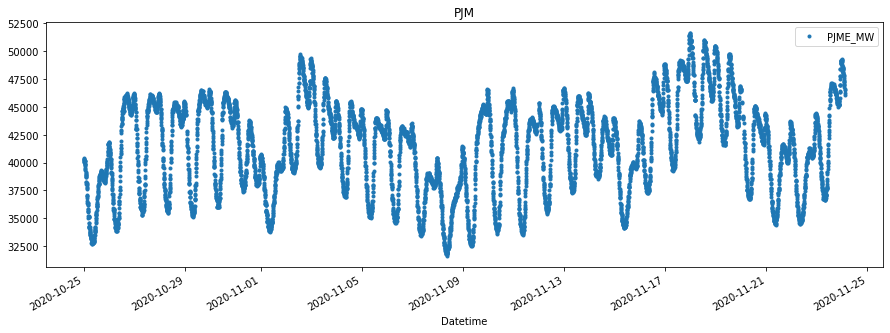

In [6]:
pjme.plot(style='.', figsize=(15,5), title='PJM');

## Spliting training and test

Data after 11/17/20 will be used as validation set

In [7]:
split_date = '11/17/20 0:00'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [8]:
len(pjme_train)

6578

In [9]:
len(pjme_test)

2021

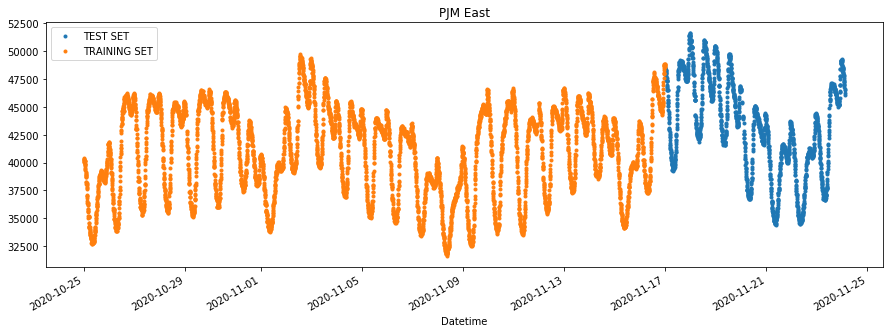

In [10]:
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.');

## Features Engineering

In [11]:
# Create features from datetime index
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour', 'dayofweek','month', 'quarter', 'year', 'dayofyear',
            'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [12]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
print(X_train.head(5))
#print(y_train.head(5))
X_test, y_test = create_features(pjme_test, label='PJME_MW')

                     hour  dayofweek  month  quarter  year  dayofyear  \
Datetime                                                                
2020-11-17 00:00:00     0          1     11        4  2020        322   
2020-11-16 23:55:00    23          0     11        4  2020        321   
2020-11-16 23:50:00    23          0     11        4  2020        321   
2020-11-16 23:45:00    23          0     11        4  2020        321   
2020-11-16 23:40:00    23          0     11        4  2020        321   

                     dayofmonth  weekofyear  
Datetime                                     
2020-11-17 00:00:00          17          47  
2020-11-16 23:55:00          16          47  
2020-11-16 23:50:00          16          47  
2020-11-16 23:45:00          16          47  
2020-11-16 23:40:00          16          47  


##  Build XGBoost Model

In [28]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #early_stopping_rounds = 50,
        verbose = True)

[0]	validation_0-rmse:28828.44531	validation_1-rmse:31101.56836
[1]	validation_0-rmse:20230.19336	validation_1-rmse:22479.08984
[2]	validation_0-rmse:14209.68262	validation_1-rmse:16305.66211
[3]	validation_0-rmse:9996.55469	validation_1-rmse:11925.54394
[4]	validation_0-rmse:7046.29199	validation_1-rmse:8782.40430
[5]	validation_0-rmse:4978.31006	validation_1-rmse:6691.89404
[6]	validation_0-rmse:3535.08496	validation_1-rmse:5289.07568
[7]	validation_0-rmse:2531.39795	validation_1-rmse:4331.37891
[8]	validation_0-rmse:1830.67688	validation_1-rmse:3724.45068
[9]	validation_0-rmse:1351.35950	validation_1-rmse:3339.13623
[10]	validation_0-rmse:1034.54419	validation_1-rmse:3086.91211
[11]	validation_0-rmse:813.10034	validation_1-rmse:2925.62891
[12]	validation_0-rmse:672.90741	validation_1-rmse:2819.42822
[13]	validation_0-rmse:594.02295	validation_1-rmse:2757.45923
[14]	validation_0-rmse:547.54553	validation_1-rmse:2703.93848
[15]	validation_0-rmse:509.38117	validation_1-rmse:2557.85132


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Feature Importances

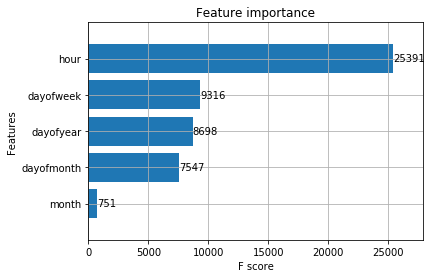

In [29]:
plot_importance(reg, height=0.8);

## Prediction on test set

In [30]:
pjme_test['MW_Prediction'] = reg.predict(X_test)

In [31]:
pjme_test.head(5)

,PJME_MW,date,hour,dayofweek,month,quarter,year,dayofyear,dayofmonth,weekofyear,MW_Prediction
Datetime,,,,,,,,,,,
2020-11-24 02:50:00,46090.6,2020-11-24 02:50:00,2,1,11,4,2020,329,24,48,45292.425781
2020-11-24 02:45:00,46276.7,2020-11-24 02:45:00,2,1,11,4,2020,329,24,48,45292.425781
2020-11-24 02:40:00,46514.4,2020-11-24 02:40:00,2,1,11,4,2020,329,24,48,45292.425781
2020-11-24 02:35:00,46568.7,2020-11-24 02:35:00,2,1,11,4,2020,329,24,48,45292.425781
2020-11-24 02:30:00,46777.5,2020-11-24 02:30:00,2,1,11,4,2020,329,24,48,45292.425781


In [32]:
pjme_all = pd.concat([pjme_test, pjme_train], sort = False)

In [33]:
pjme_all.shape

(8599, 11)

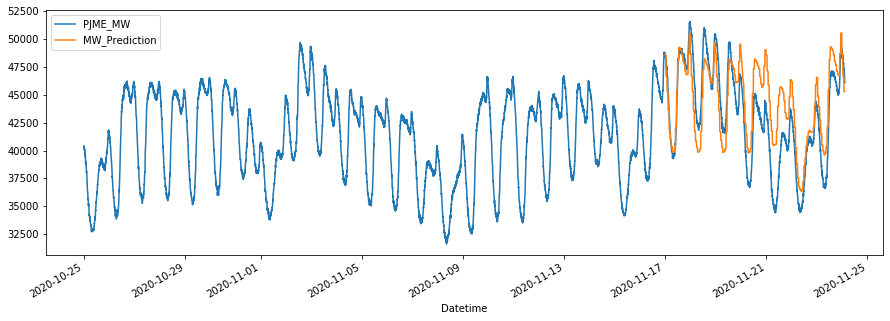

In [34]:
pjme_all[['PJME_MW', 'MW_Prediction']].plot(figsize=(15,5));

## Save model to s3

In [20]:
model_file_name = "load-forecast-xgb"
reg._Booster.save_model(model_file_name)

In [21]:
# zip model file

!tar czvf model.tar.gz $model_file_name

load-forecast-xgb


## Upload the pre-trained model to S3

In [22]:
region = 'us-east-1'
bucket = "pjm-load-forecast"
prefix = 'sagemaker/pjm-forecast-xgboost-byo'
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region, bucket)

fObj = open("model.tar.gz", 'rb')
key= os.path.join(prefix, model_file_name, 'model.tar.gz')
boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(fObj)

# Setting up hosting for model

## get inference image

In [23]:
import sagemaker
#container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-2')
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "1.2-1")

In [24]:
%%time
from time import gmtime, strftime
from sagemaker import get_execution_role

model_name = model_file_name + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model_url = 'https://s3-{}.amazonaws.com/{}/{}'.format(region,bucket,key)
sm_client = boto3.client('sagemaker')

print (model_url)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_url,
}
role = get_execution_role()
create_model_response2 = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

#print(create_model_response2['ModelArn'])

https://s3-us-east-1.amazonaws.com/pjm-load-forecast/sagemaker/pjm-forecast-xgboost-byo/load-forecast-xgb/model.tar.gz
CPU times: user 183 ms, sys: 20.6 ms, total: 204 ms
Wall time: 1.81 s


## Endpoint configuration

In [25]:
from time import gmtime, strftime

endpoint_config_name = 'PJM-LoadForecast-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialInstanceCount':1,
        'InitialVariantWeight':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

#print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

PJM-LoadForecast-XGBoostEndpointConfig-2020-11-25-00-26-25


## Create Endpoint

In [98]:
%%time
import time

endpoint_name = 'PJM-LoadForecast-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
#print(create_endpoint_response['EndpointArn'])

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

#print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

PJM-LoadForecast-XGBoostEndpoint-2020-11-24-06-08-26
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Status: InService
CPU times: user 203 ms, sys: 1.1 ms, total: 204 ms
Wall time: 11min 1s


## Validation

In [70]:
runtime_client = boto3.client('runtime.sagemaker')

In [71]:
import numpy as np
print(X_test.iloc[5])
#point_X = X_test[0]
point_X = X_test.iloc[5]
#print(point_X)
point_X = np.expand_dims(point_X, axis=0)
point_y = y_test.iloc[5]
np.savetxt("test_point.csv", point_X, delimiter=",")

hour             2
dayofweek        1
month           11
quarter          4
year          2020
dayofyear      329
dayofmonth      24
weekofyear      48
Name: 2020-11-24 02:25:00, dtype: int64


In [72]:
%%time
import json


file_name = 'test_point.csv' #customize to your test file, will be 'mnist.single.test' if use data above

with open(file_name, 'r') as f:
    payload = f.read().strip()
print('payload',payload)
response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/csv', 
                                   Body=payload)
result = response['Body'].read().decode('ascii')
print(point_y)
print('Predicted Class Probabilities: {}.'.format(result))

46957.1
Predicted Class Probabilities: 45254.2890625.
CPU times: user 14.2 ms, sys: 50 µs, total: 14.3 ms
Wall time: 171 ms
